## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions

# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
print(tf.__version__)
print(tfp.__version__)

2.1.0
0.9.0


## Distributions

In [3]:
normal = tfd.Normal(loc=0.0, scale=1.0)
gamma = tfd.Gamma(concentration=5.0, rate=1.0)
poisson = tfd.Poisson(rate=2.0)
laplace = tfd.Laplace(loc=0.0, scale=1.0)

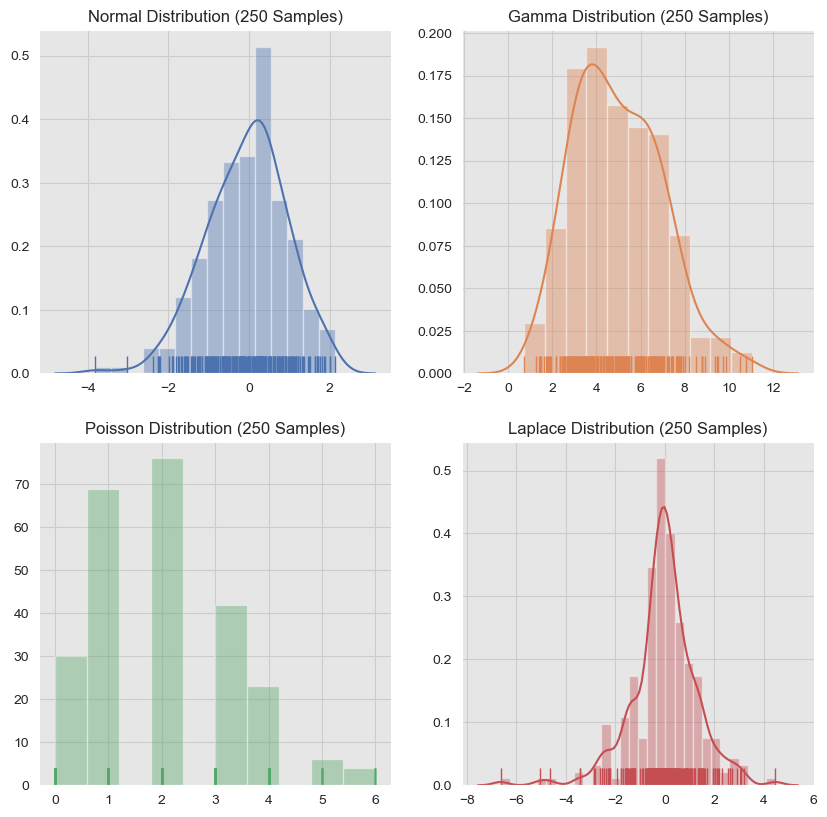

In [4]:
tf.random.set_seed(42)

n_samples = 250

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

sns.distplot(a=normal.sample(n_samples), color=sns_c[0], rug=True, ax=axes[0])
axes[0].set(title=f'Normal Distribution ({n_samples} Samples)')

sns.distplot(a=gamma.sample(n_samples), color=sns_c[1], rug=True, ax=axes[1])
axes[1].set(title=f'Gamma Distribution ({n_samples} Samples)');

sns.distplot(a=poisson.sample(n_samples), color=sns_c[2], kde=False, rug=True, ax=axes[2])
axes[2].set(title=f'Poisson Distribution ({n_samples} Samples)');

sns.distplot(a=laplace.sample(n_samples), color=sns_c[3], rug=True, ax=axes[3])
axes[3].set(title=f'Laplace Distribution ({n_samples} Samples)');

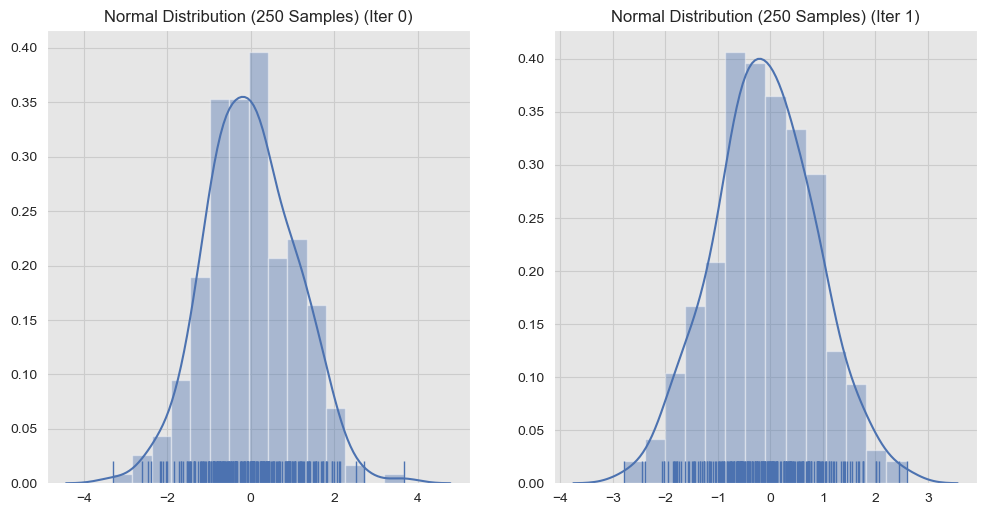

In [5]:
normal_samples = normal.sample([n_samples, n_samples])

fig, axes = plt.subplots(1, 2)

axes = axes.flatten()

for i in range(2):
    sns.distplot(a=normal_samples[i], color=sns_c[0], rug=True, ax=axes[i])
    axes[i].set(title=f'Normal Distribution ({n_samples} Samples) (Iter {i})')